<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Computing-enrichment-radius" data-toc-modified-id="Computing-enrichment-radius-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Computing enrichment radius</a></span></li><li><span><a href="#More-maximalist/exact-approach-to-computing-enrichment-radius" data-toc-modified-id="More-maximalist/exact-approach-to-computing-enrichment-radius-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>More maximalist/exact approach to computing enrichment radius</a></span></li><li><span><a href="#Testing-autocorrelations" data-toc-modified-id="Testing-autocorrelations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing autocorrelations</a></span><ul class="toc-item"><li><span><a href="#Luumbo-round-4-vs-round-10" data-toc-modified-id="Luumbo-round-4-vs-round-10-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Luumbo round 4 vs round 10</a></span></li><li><span><a href="#Gwembe-round-4-(to-compare-to-Jaline)" data-toc-modified-id="Gwembe-round-4-(to-compare-to-Jaline)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Gwembe round 4 (to compare to Jaline)</a></span></li></ul></li><li><span><a href="#Switching-from-a-global-picture-to-instead,-aggregating-local-picture-(see-convo-with-Jaline)" data-toc-modified-id="Switching-from-a-global-picture-to-instead,-aggregating-local-picture-(see-convo-with-Jaline)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Switching from a global picture to instead, aggregating local picture (see convo with Jaline)</a></span><ul class="toc-item"><li><span><a href="#Aggregating-a-different-way:-preserve-distributions" data-toc-modified-id="Aggregating-a-different-way:-preserve-distributions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Aggregating a different way: preserve distributions</a></span></li><li><span><a href="#Jan-16-for-wiki-post" data-toc-modified-id="Jan-16-for-wiki-post-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Jan 16 for wiki post</a></span></li><li><span><a href="#Splitting-by-population-density" data-toc-modified-id="Splitting-by-population-density-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Splitting by population density</a></span></li></ul></li></ul></div>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

import scipy
from scipy.spatial import KDTree, cKDTree
from scipy.stats import binom_test

import time

In [56]:
# Compute average prevalence for each catchment at each round, and save:
# catch | round | n_obs | n_pos | pos_frac

# Import relevant columns of rounds data
fn = "C:/Users/jsuresh/Dropbox (IDM)/Malaria Team Folder/data/Zambia/MACEPA/rounds_data/cleaned_and_merged/masterDatasetAllRounds2012-2016.csv"
df = pd.read_csv(fn, usecols=["person_id", "catch", "round", "latitude", "longitude", "rdt_pos"])
df.dropna(subset=["rdt_pos", "latitude", "longitude"], inplace=True)  #Drop any NAN RDT values (~8% of all)


df = df[np.logical_and(df["latitude"]>=-18.1022, df["latitude"] <= -15.65)]
df = df[np.logical_and(df["longitude"]>=25.7739, df["longitude"] <= 29.068549)]

In [12]:
c = []
r = []
n_obs = []
n_pos = []
pos_frac = []

for index, sdf in df.groupby(["round", "catch"]):
    r.append(index[0])
    c.append(index[1])
    
    no = len(sdf)  #nunique might be safer?
    np = sdf["rdt_pos"].sum()
    pf = np/no
    
    n_obs.append(no)
    n_pos.append(np)
    pos_frac.append(pf)
    
new_df = pd.DataFrame({
    "catch": c,
    "round": r,
    "n_obs": n_obs,
    "n_pos": n_pos,
    "pos_frac": pos_frac
})

new_df.to_csv("catch_round_prev.csv", index=False)

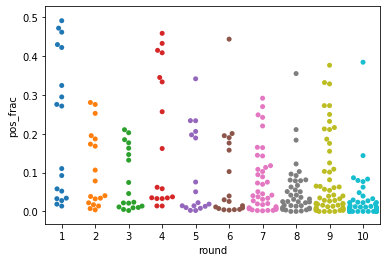

In [56]:
# Sanity plot:
# plt.scatter(new_df["round"], new_df["pos_frac"])
sns.swarmplot(x="round", y="pos_frac", data=new_df)

In [57]:
# Impose a minimum threshold of 50 people observed in the catchment:
background_pos = new_df[new_df["n_obs"] >= 50].reset_index()

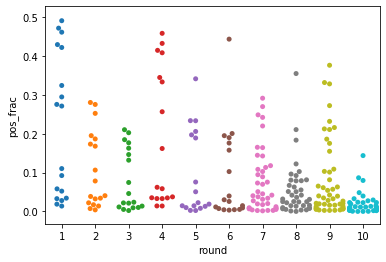

In [58]:
sns.swarmplot(x="round", y="pos_frac", data=background_pos)

# Computing enrichment radius 

In [13]:
catch_background_pos = pd.read_csv("catch_round_prev.csv")

In [57]:
def add_xy_coords_metric(sdf, recenter=False):
    # Convert lat/long to x-y for easier distance calculations on kd-tree
    RE = 6378100 # radius of the earth in meters
    
    lon_rad = sdf["longitude"]*scipy.pi/180
    lat_rad = sdf["latitude"]*scipy.pi/180
    
    #small angle approximation: sin(theta) ~ theta if theta is very small
    x = RE*lon_rad * np.cos(np.mean(lat_rad))
    y = RE*lat_rad 
    
    if recenter:
        sdf["x"] = x-np.mean(x)
        sdf["y"] = y-np.mean(y)
    else:
        sdf["x"] = x
        sdf["y"] = y
    return sdf
    # d = R * sqrt( dx**2 + dy**2 )
    
    
def calc_enrichment_radii(sdf):
    # Assumes sdf is grouped by catch and round.
    
    r_bins = [5,10,25,50,75,100,125,140,150,175,200]
    
    # Calculate kd-tree
    # Loop over every person, and compute enrichment at each radial bin 
    
def background_catch_pos(catch, rd):
    sdf = catch_background_pos[np.logical_and(catch_background_pos["catch"]==catch,
                                             catch_background_pos["round"]==rd)]
    return sdf["pos_frac"].iloc[0]
    
    

In [26]:
testing = 1
for r, sdf in df.groupby(["round", "catch"]):
    
    if testing == 1:
        foo = add_xy_coords_metric(sdf, recenter=True)
        
        rd = r[0]
        catch = r[1]

        d = np.array(foo[["x", "y"]])
        kdt = KDTree(d)
    
    testing += 1
        

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [162]:
testing = 1
for r, sdf in df.groupby(["round"]):
    
    if testing == 1:
        foo = add_xy_coords_metric(sdf, recenter=True)
        
        rd = r

        d = np.array(foo[["x", "y"]])
        kdt = KDTree(d)
    
    testing += 1

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [58]:
def positivity_within_radius(X, kdt, rdt_pos, r, minus_one_correction = True):
    near_pts = kdt.query_ball_point(X,r)
    num_near_pts = np.float(len(near_pts))
        
    if minus_one_correction:
        pos = (np.sum(rdt_pos[near_pts])-1)/(num_near_pts-1) # minus one to not recount index person themselves
    else:
        pos = (np.sum(rdt_pos[near_pts]))/(num_near_pts)
    
    return pos, num_near_pts-1


rbins_default = [20,40,60,80,100,120,140,160,180,200,300,400,1000]
def enrich_radius_with_bins(sdf_with_xy, 
                                 kdt, 
                                 rbins = rbins_default,
                                 pos_backgrd = -1,
                                 method="enrich_factor",
                                 ef_thresh=2,
                                 pv_thresh=0.1,
                                **kwargs):
    # sdf_with_xy: dataframe of people with rdt_pos, and x-y coordinates in meters
    # kdt: KDTree object
    pos_individuals_xy = np.array(sdf_with_xy[["x", "y"]][sdf_with_xy["rdt_pos"]==1])
    rdt_pos = np.array(sdf_with_xy["rdt_pos"])
    
    if pos_backgrd == -1:
        print("Background positivity to compare to not supplied.  Will use largest radius (r = {}) as background circle around each individual".format(np.max(rbins)))
        calc_pos_backgrd = True
    else:
        calc_pos_backgrd = False
    
    re_list = []
    pb_list = []
    
    for X in pos_individuals_xy:
        
        if calc_pos_backgrd: # calculate background positivity by taking largest radius given
            pos_backgrd, num_near_pts = positivity_within_radius(X, kdt, rdt_pos, np.max(rbins))
            
#             if pos_backgrd == 0:
#                 print("Found a place with zero rdt_positives in 1k circle!")
            
        
        if pos_backgrd == 0:
            re = 0
            re_found = True
        else:
            re = -1
            re_found = False
        
        
        
        for r in rbins:
            if not re_found:
                if r == rbins[0]:
                    old_num_near_pts = 1 

                pos, num_near_pts = positivity_within_radius(X, kdt, rdt_pos, r)

                # Only consider this point if it includes more people than the next-smaller radius
                if num_near_pts > old_num_near_pts:
                    
                    if method == "binomial_test":
                        # Perform hypothesis test (might be too strict)
                        pv = binom_test(pos*num_near_pts, num_near_pts, pos_backgrd,  alternative='greater')
                        
                        if pv > pv_thresh:
                            re = r
                            re_found = True
                        
                    elif method == "enrich_factor":
                        # Another metric: enrichment factor > some threshold
                        ef = pos/pos_backgrd
                        
                        if ef <= ef_thresh:
                            re = r
                            re_found = True
                            
                            
                old_num_near_pts = num_near_pts
                            
        
        if not re_found and num_near_pts != 1:
            print("Re not found, and number of nearby points is > 1?  Something's wrong.")
            
            print(ef)
            print("pos ", pos)
            print("pos_backgrd ", pos_backgrd)
            print(r)
            print(X)
            print("num_near_pts ", num_near_pts)
            
        re_list.append(re)
        pb_list.append(pos_backgrd)

    return re_list, pb_list

In [192]:
# r1 = enrich_radius_for_individual(foo, kdt, method="binomial_test")
r2, pb = enrich_radius_for_individual(foo, kdt, method="enrich_factor", ef_thresh=2)

Background positivity to compare to not supplied.  Will use largest radius (r = 1000) as background circle around each individual


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


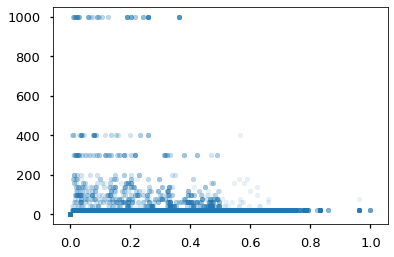

In [203]:
plt.scatter(pba, r2a, marker='.', alpha=0.1)

In [198]:
pba = np.array(pb)
r2a = np.array(r2)
for i in np.arange(10):
    if i != 0:
        c = np.logical_and(pba > (i-1)*0.1, pba<i*0.1) 
        print(np.mean(r2a[c]))
#         print(np.median(r2a[c]))
# plt.scatter(np.array(pb), np.array(r2))



115.46313799621929
64.22018348623853
57.19115734720416
35.80678314491264
22.61933904528764
20.39827771797632
20.188470066518846
20.0
20.0


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


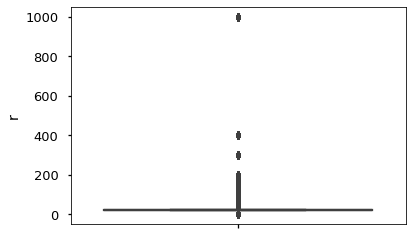

In [188]:
hold = pd.DataFrame({"r": r2,
                    "r_type": "r2"})
sns.boxplot(y="r", data=hold)

In [137]:
r1 = enrich_radius_for_individual(foo, kdt, method="binomial_test")
r2 = enrich_radius_for_individual(foo, kdt, method="enrich_factor", ef_thresh=2)
r3 = enrich_radius_for_individual(foo, kdt, method="enrich_factor", ef_thresh=3)

Background positivity to compare to not supplied.  Will use largest radius (r = 1000) as background circle around each individual


IndexError: index 69724 is out of bounds for axis 0 with size 1439

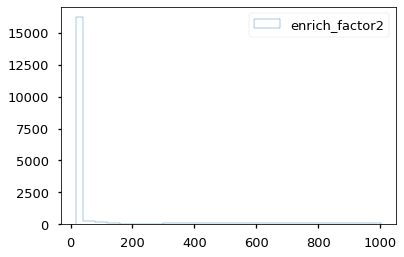

In [155]:
b = np.array(rbins_default)
b -= 1
b = np.append(b, np.max(rbins_default)+1)
# plt.hist(r1,bins=b,label="binomial_test", alpha=1)
plt.hist(r2,bins=b, histtype='step',label="enrich_factor2", alpha=1)
# plt.hist(r3,bins=b, histtype='step',label="enrich_factor3", alpha=1)
plt.legend()

(0, 100)

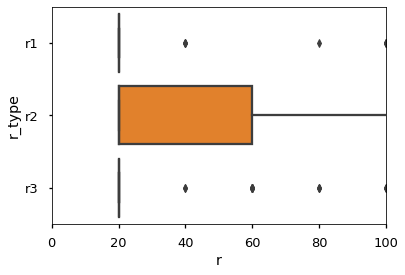

In [135]:
hold = pd.DataFrame({
    "r_type": ["r1"]*len(r1) + ["r2"] * len(r2) + ["r3"] * len(r3),
    "r": r1+r2+r3
})

sns.boxplot(x="r",y="r_type",data=hold)
# plt.legend()
plt.xlim([0,100])

In [115]:
np.append(b,5)
b

array([ 19,  39,  59,  79,  99, 119, 139, 159, 179, 199, 299, 399, 999])

In [61]:
dd = np.array(foo[["x", "y"]][foo["rdt_pos"]==1])

aa = []
bb = []
pp = []
nn = []
re = []
vel = []

rdt_pos = np.array(foo["rdt_pos"])

pv_thresh = 0.1
# 

i=1
for a in dd:
    i+=1
    print(i)
    for r in [20,40,60,80,100,120,140,160,180,200,300,400,1000]:
        if r == 20:
            old_num_near_pts = 1
        
        near_pts = kdt.query_ball_point(a,r)
        num_near_pts = np.float(len(near_pts))
        
        if num_near_pts > old_num_near_pts:
            pos = (np.sum(rdt_pos[near_pts])-1)/num_near_pts #minus one to not recount index person themselves
            pos_backgrd = background_catch_pos(catch, rd)
    #         print("background positivity ", pos_backgrd)


            # Perform hypothesis test (might be too strict)
            p = binom_test(np.sum(rdt_pos[near_pts]), num_near_pts, pos_backgrd,  alternative='greater')
#             print(len(near_pts))
#             print("p-value", p)

            # Another metric: enrichment factor > some threshold
            ve = pos/pos_backgrd
            
    #         print(pos)
            aa.append(pos)
            bb.append(r)
            pp.append(p)
            nn.append(len(near_pts))
            vel.append(ve)
            old_num_near_pts = num_near_pts

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


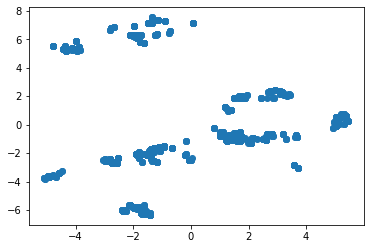

In [39]:
plt.scatter(foo["x"]/1000., foo["y"]/1000.)

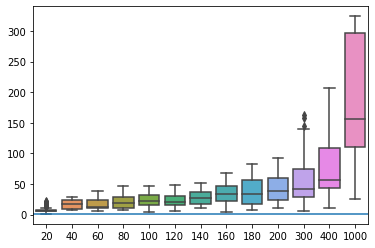

In [47]:
sns.boxplot(np.array(bb), np.array(nn))
plt.axhline(0.05)

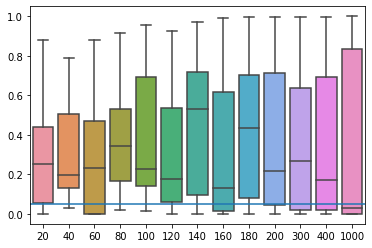

In [54]:
sns.boxplot(np.array(bb), np.array(pp))
plt.axhline(0.05)

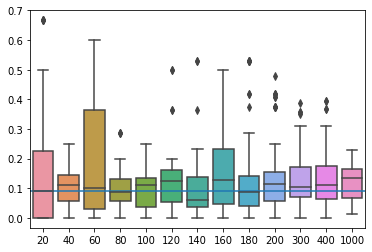

In [62]:
sns.boxplot(np.array(bb), np.array(aa))
plt.axhline(0.092425295)

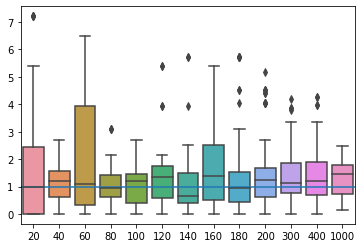

In [63]:
sns.boxplot(np.array(bb), np.array(vel))
plt.axhline(1)

In [ ]:

    # Set origin of (x,y) to be min lat/lon

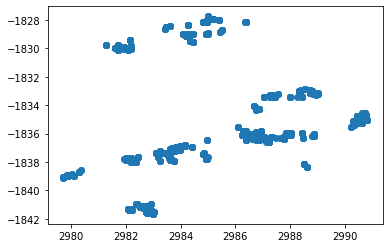

In [78]:
plt.scatter(foo["x"]/1000, foo["y"]/1000)
# plt.axvline(-17.982947)
# plt.axvline(-16.420246)
# plt.axhline(27.002105)
# plt.axhline(29.068549)
plt.show()

# More maximalist/exact approach to computing enrichment radius

In [300]:
def calc_background_positivity_for_pos_individuals(sdf_with_xy, kdt, d_circle=3000):
    pos_cut = sdf_with_xy["rdt_pos"]==1
    pos_ii = np.arange(len(sdf_with_xy))[pos_cut]
    n_pos = np.sum(pos_cut)
    pos_individuals_xy = np.array(sdf_with_xy[["x", "y"]][pos_cut])
    
    rdt_pos = np.array(sdf_with_xy["rdt_pos"])
    x = np.array(sdf_with_xy["x"])
    y = np.array(sdf_with_xy["y"])
    
    near_pts_list = kdt.query_ball_point(pos_individuals_xy, d_circle)
    
    bp_arr = np.zeros(n_pos)
    
    i = 0
    for near_pts in near_pts_list:
        num_near_pts = len(near_pts)
        pos_backgrd = (np.sum(rdt_pos[near_pts])-1)/(num_near_pts-1) # minus one to not recount index person themselves
        bp_arr[i] = pos_backgrd
        i += 1
        
    return bp_arr

In [435]:
def exact_enrich_radius_for_individual(sdf_with_xy, kdt, background_positivity, d_circle_max=300, p_thresh=0.1, min_num_nearby=30):
    # sdf_with_xy: dataframe of people with rdt_pos, and x-y coordinates in meters
    # kdt: KDTree object
    pos_cut = sdf_with_xy["rdt_pos"]==1
    pos_ii = np.arange(len(sdf_with_xy))[pos_cut]
    n_pos = np.sum(pos_cut)
    
    xy = np.array(sdf_with_xy[["x", "y"]])
    rdt_pos = np.array(sdf_with_xy["rdt_pos"])
    x = np.array(sdf_with_xy["x"])
    y = np.array(sdf_with_xy["y"])
    
    n_pos = len(pos_individuals_xy)
    r1_arr = np.zeros(n_pos)
    r2_arr = np.zeros(n_pos)
    r3_arr = np.zeros(n_pos)
    pv_index_hh = np.zeros(n_pos)
    ef_index_hh = np.zeros(n_pos)
    
    xxc = ckdt.query_ball_point(pos_individuals_xy, d_circle_max)
    
    kk = 0
    for pos_i in np.arange(n_pos):
#         if kk == 0:
        X = pos_individuals_xy[pos_i]
        near_pts = xxc[pos_i]
        num_near_pts = len(near_pts)

        d = np.sqrt((x[near_pts]-X[0])**2 + (y[near_pts]-X[1])**2)
        pos_backgrd = background_positivity[pos_i]

        if num_near_pts < min_num_nearby:
            r1 = -3
            r2 = -3
            r3 = -3
        elif pos_backgrd == 0:
            r1 = -2
            r2 = -2
            r3 = -2
        else:
            # Calculate p-value and enrichment value for everyone
            dsort = np.argsort(d)
            d_sorted = d[dsort]
            rdt_pos_sorted = rdt_pos[dsort]

            n_interior = (np.arange(num_near_pts)+1).astype("float")
            n_pos = (np.cumsum(rdt_pos_sorted)).astype("float")

            positivity = (n_pos-1)/(n_interior-1)
            positivity[0] = 1
            enrichment_factor = positivity/pos_backgrd

            p_values = np.zeros_like(n_interior)
            for i in np.arange(num_near_pts):
                p_values[i] = 1
                p_values[i] = binom_test(n_pos[i], n_interior[i], pos_backgrd, alternative='greater')
    #             print(positivity[i])
    #             print(pos_backgrd)
            # Can optimize this later:
    #         binom_test_vectorized = np.vectorize(binom_test)
    #         pv = binom_test_vectorized()
    #         pv = binom_test(pos*num_near_pts, num_near_pts, pos_backgrd, alternative='greater')


            # Find minimum radius at which enrichment criteria is no longer satisfied:
            # Problem: this treats people as individuals, whereas really we want to think in terms of households:
#             ii = np.arange(num_near_pts) # index for each position
#     #         print(n_pos)
#     #         print(n_interior)
#             min_circle_cut = np.logical_and(n_interior >= 5, d_sorted >= 1)
#             c1 = np.logical_and(min_circle_cut, p_values > p_thresh) #p-value threshold
#             c2 = np.logical_and(min_circle_cut, enrichment_factor <= 2)
#             c3 = np.logical_and(min_circle_cut, enrichment_factor <= 3)

#             if np.sum(c1) > 0:
#                 i1 = np.min(ii[c1])-1
#                 r1 = d_sorted[i1]
# #                 pvf = p_values
#             else:
#                 r1 = -1

#             if np.sum(c2) > 0:
#                 i2 = np.min(ii[c2])-1
#                 r2 = d_sorted[i2]
#             else:
#                 r2 = -1

#             if np.sum(c3) > 0:
#                 i3 = np.min(ii[c3])-1
#                 r3 = d_sorted[i3]
#             else:
#                 r3 = -1

            d_by_hh = np.unique(d_sorted)
            ii = np.arange(num_near_pts)
            
            r1_found = False
            r2_found = False
            r3_found = False
            
            for d_hh in d_by_hh:
                cut = d_sorted <= d_hh
                ii_cut = ii[cut]
                ii_max = np.max(ii_cut)
                
                pv_hh = p_values[ii_max]
                ef_hh = enrichment_factor[ii_max]
                
                if d_hh == 0:
                    pv_index_hh[kk] = pv_hh
                    ef_index_hh[kk] = ef_hh
                
                if pv_hh > p_thresh and not r1_found:
                    r1_found = True
                    r1 = d_hh
                
                if ef_hh <= 1 and not r2_found:
                    r2_found = True
                    r2 = d_hh
                    
                if ef_hh <= 2 and not r3_found:
                    r3_found = True
                    r3 = d_hh
                    
                    


#         plt.plot(np.arange(len(enrichment_factor)), enrichment_factor)

        r1_arr[kk] = r1
        r2_arr[kk] = r2
        r3_arr[kk] = r3
        
#         if r1 >250 or r1 == 0:
# #             print("pv ",p_values)
#             print(d_sorted)
#         if r2 >250 or r3 >250 or r2 == 0 or r3 == 0:
# #             print("ef ", enrichment_factor)
#             print(d_sorted)
        
        kk += 1
        if kk%1000 == 0:
            print(kk)

        
    return [r1_arr, r2_arr, r3_arr, pv_index_hh, ef_index_hh]
        
        

In [446]:
# Test
rd = 10

sdf = df[df["round"]==rd]
foo = add_xy_coords_metric(sdf, recenter=True)

d = np.array(foo[["x", "y"]])
ckdt = cKDTree(d)

pos_cut = foo["rdt_pos"]==1
pos_individuals_xy = np.array(foo[["x", "y"]][pos_cut])
bp_arr = calc_background_positivity_for_pos_individuals(foo, ckdt)

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [448]:
a,b,c,d,e = exact_enrich_radius_for_individual(foo, kdt, bp_arr, min_num_nearby=25)

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


1000
2000


In [439]:
df_save = pd.DataFrame({
    "r1": a,
    "r2": b,
    "r3": c
})

df_save.to_csv("round1.csv", index=False)

In [447]:
len(sdf)

143031

(array([1618.,   20.,   15.,    5.,    0.,    2.]),
 array([  0,   1,  20,  50, 100, 150, 300]),
 <a list of 1 Patch objects>)

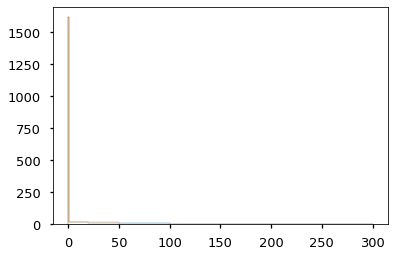

In [449]:
# plt.hist(a[a>=0], histtype='step', bins=(0,1,20,50,100,150,300))
plt.hist(b[b>=0], histtype='step', bins=(0,1,20,50,100,150,300))
plt.hist(c[c>=0], histtype='step', bins=(0,1,20,50,100,150,300))

In [386]:
def plot_scatter(v, bp, bin_width=0.1):
    bins = np.arange(0,np.max(bp)+bin_width, bin_width)
    
    m = np.zeros_like(bins)
    i = 0
    for b in bins:
        cut = np.logical_and(v >= b-bin_width, v <= b)
        m[i] = np.mean(v[cut])
        i += 1
        
    plt.plot(bins, m, color='red', zorder=3)
    print(m)

In [393]:
np.sum(a == 0)

12070

c:\users\jsuresh\venv\idm\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\jsuresh\venv\idm\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.         0.                nan 0.25689978 0.37106281        nan
        nan 0.6603783  0.7516502 ]


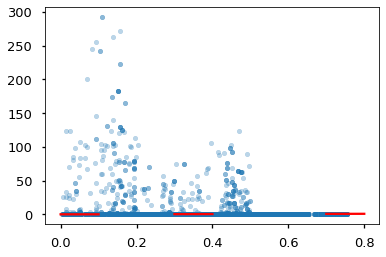

In [414]:
plt.scatter(bp_arr[b>=0], b[b>=0], marker='.', alpha=0.3)
plot_scatter(b[b>=0], bp_arr[b>=0])

In [376]:
aa,bb,cc = exact_enrich_radius_for_individual(foo, kdt, bp_arr)

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


1000


KeyboardInterrupt: 

In [204]:
testing = 1
for r, sdf in df.groupby(["round"]):
    
    if testing == 1:
        foo = add_xy_coords_metric(sdf, recenter=True)
        
        rd = r

        d = np.array(foo[["x", "y"]])
        ckdt = cKDTree(d)
    
    testing += 1

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Testing autocorrelations

In [51]:
# Test
rd = 4

sdf = df[df["round"]==rd]
foo = add_xy_coords_metric(sdf, recenter=True)

d = np.array(foo[["x", "y"]])
ckdt_all = cKDTree(d)

pos_cut = foo["rdt_pos"]==1
pos_individuals_xy = np.array(foo[["x", "y"]][pos_cut])
ckdt_pos = cKDTree(pos_individuals_xy)

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


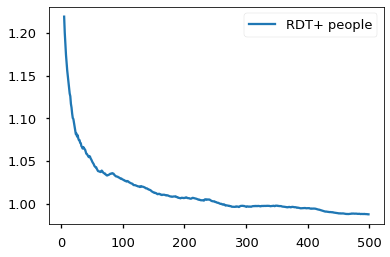

In [54]:
rbins = np.arange(5,500)
# rbins = np.array([1,50,200])
a = scipy.pi * rbins**2 # Dividing by a doesn't affect results, but just makes them near-impossible to see at larger radii
c_pos = ckdt_pos.count_neighbors(ckdt_pos, rbins)
c_all = ckdt_pos.count_neighbors(ckdt_all, rbins)
# plt.plot(rbins, c_pos/np.sum(c_pos), label="RDT+ people")
# plt.plot(rbins, c_all/np.sum(c_all), label="All people")
plt.plot(rbins, c_pos/np.sum(c_pos)/(c_all/np.sum(c_all)), label="RDT+ people")
# plt.plot(rbins, np.cumsum(c_pos/np.sum(c_pos)/(c_all/np.sum(c_all))), label="RDT+ people")
# plt.axhline(1)
# plt.plot(rbins, c_all/np.sum(c_all), label="All people")
plt.legend()

In [30]:
print(c_pos/a/np.max(c_pos))
print(c_all/a/np.max(c_all))

[1.31756220e-01 6.38827827e-05 7.95774715e-06]
[3.99974505e-02 3.14787099e-05 7.95774715e-06]


## Luumbo round 4 vs round 10

In [478]:
catch = "Luumbo"
rd = 10

sdf = df[np.logical_and(df["round"]==rd, df["catch"]==catch)]
foo = add_xy_coords_metric(sdf, recenter=True)

d = np.array(foo[["x", "y"]])
ckdt_all = cKDTree(d)

pos_cut = foo["rdt_pos"]==1
pos_individuals_xy = np.array(foo[["x", "y"]][pos_cut])
ckdt_pos = cKDTree(pos_individuals_xy)

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


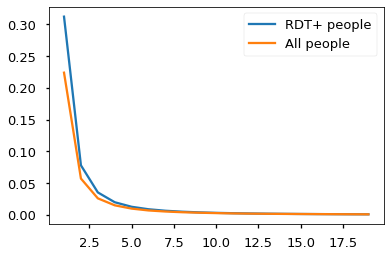

In [480]:
rbins = np.arange(0,20)
a = scipy.pi * rbins**2
c_pos = ckdt_pos.count_neighbors(ckdt_pos, rbins)
c_all = ckdt_all.count_neighbors(ckdt_all, rbins)
plt.plot(rbins, c_pos/a/np.max(c_pos), label="RDT+ people")
plt.plot(rbins, c_all/a/np.max(c_all), label="All people")
plt.legend()

In [481]:
catch = "Luumbo"
rd = 4

sdf = df[np.logical_and(df["round"]==rd, df["catch"]==catch)]
foo = add_xy_coords_metric(sdf, recenter=True)

d = np.array(foo[["x", "y"]])
ckdt_all = cKDTree(d)

pos_cut = foo["rdt_pos"]==1
pos_individuals_xy = np.array(foo[["x", "y"]][pos_cut])
ckdt_pos = cKDTree(pos_individuals_xy)

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


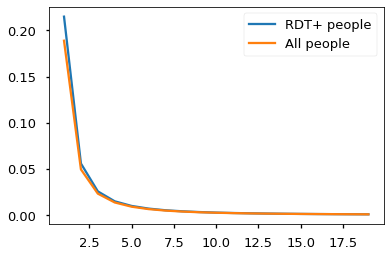

In [482]:
rbins = np.arange(0,20)
a = scipy.pi * rbins**2
c_pos = ckdt_pos.count_neighbors(ckdt_pos, rbins)
c_all = ckdt_all.count_neighbors(ckdt_all, rbins)
plt.plot(rbins, c_pos/a/np.max(c_pos), label="RDT+ people")
plt.plot(rbins, c_all/a/np.max(c_all), label="All people")
plt.legend()

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


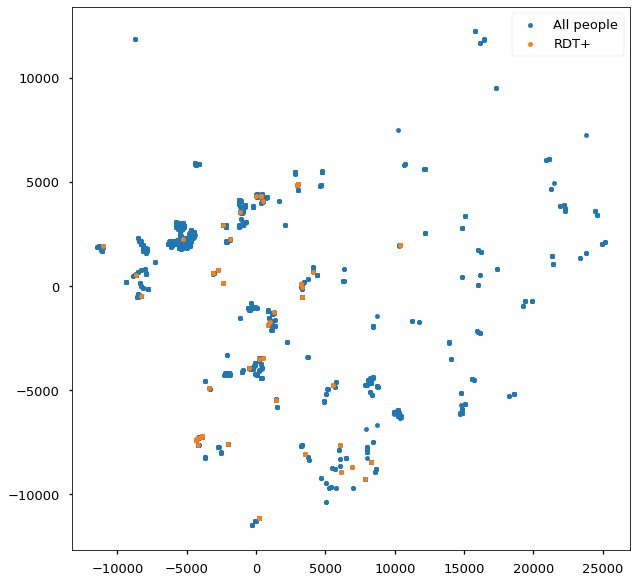

In [491]:
catch = "Luumbo"
rd = 10
sdf = df[np.logical_and(df["round"]==rd, df["catch"]==catch)]
foo = add_xy_coords_metric(sdf, recenter=True)

d = np.array(foo[["x", "y"]])

pos_cut = foo["rdt_pos"]==1
pos_individuals_xy = np.array(foo[["x", "y"]][pos_cut])

plt.figure(figsize=(10,10))
plt.scatter(d[:,0], d[:,1], marker='.', label="All people")
plt.scatter(pos_individuals_xy[:,0], pos_individuals_xy[:,1], marker='.', label="RDT+")
plt.legend()

In [457]:
len(rbins)

49

In [460]:
rbins

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490])

## Gwembe round 4 (to compare to Jaline)

In [518]:
catch = "Gwembe"
rd = 1

sdf = df[np.logical_and(df["round"]==rd, df["catch"]==catch)]
foo = add_xy_coords_metric(sdf, recenter=True)

d = np.array(foo[["x", "y"]])
ckdt_all = cKDTree(d)

pos_cut = foo["rdt_pos"]==1
pos_individuals_xy = np.array(foo[["x", "y"]][pos_cut])
ckdt_pos = cKDTree(pos_individuals_xy)

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [527]:
n_all = len(d)
n_pos = len(pos_individuals_xy)

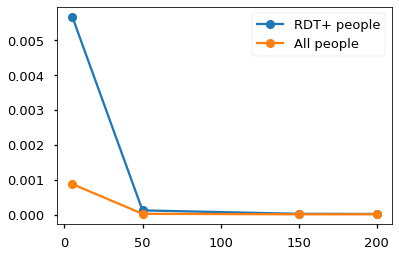

In [523]:
rbins = np.array([5,50,150,200])
# rbins = np.arange(20)
a = scipy.pi * rbins**2
c_pos = ckdt_pos.count_neighbors(ckdt_pos, rbins)
c_all = ckdt_pos.count_neighbors(ckdt_all, rbins)
plt.plot(rbins, np.cumsum(c_pos)/a/np.max(c_pos), label="RDT+ people", marker='o')
plt.plot(rbins, np.cumsum(c_all)/a/np.max(c_all), label="All people", marker='o')
plt.legend()
# plt.xlim([0,210])

In [535]:
rbins = np.array([5,50,150,200])
# rbins = np.arange(20)
a = scipy.pi * rbins**2
# c_pos = ckdt_pos.count_neighbors(ckdt_pos, rbins)
# c_all = ckdt_pos.count_neighbors(ckdt_all, rbins)

x1 = np.array([])
x2 = np.array([])
for r in rbins:
    print(r)
    c_pos = ckdt_pos.count_neighbors(ckdt_pos, r)/n_pos
    c_all = ckdt_pos.count_neighbors(ckdt_all, r)/n_all
    print(c_pos)
    print(c_all)
    print(c_pos/c_all)
    



# plt.plot(rbins, np.cumsum(c_pos)/np.cumsum(c_all), label="Ratio", marker='o')
# # plt.plot(rbins, np.cumsum(c_all)/a/np.max(c_all), label="All people", marker='o')
# plt.legend()
# # plt.xlim([0,210])

5
1.2758620689655173
0.06711089957163256
19.011249694301785
50
1.5517241379310345
0.14516896715849595
10.689089881288863
150
2.6551724137931036
0.6877677296525464
3.860565564968381
200
2.8620689655172415
0.9709662065683008
2.9476504394861394


[0.44578313 0.54216867 0.92771084 1.        ]
[0.06911765 0.1495098  0.70833333 1.        ]
[6.4496283  3.62630851 1.30970943 1.        ]


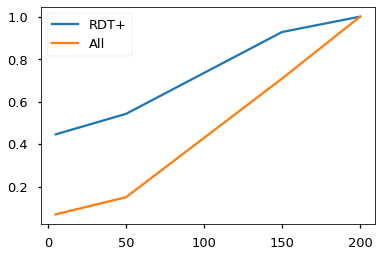

In [552]:
rbins = np.array([5,50,150,200])
# rbins = np.arange(20)
a = scipy.pi * rbins**2
c_pos = ckdt_pos.count_neighbors(ckdt_pos, rbins) #/np.max(c_pos)
c_all = ckdt_pos.count_neighbors(ckdt_all, rbins) #/np.max(c_all)

c_pos = c_pos/np.max(c_pos)
c_all = c_all/np.max(c_all)
print(c_pos)

print(c_all)
plt.plot(rbins, c_pos, label="RDT+")
plt.plot(rbins, c_all, label="All")
plt.legend()

print(c_pos/c_all)

In [537]:
n_pos

29

In [538]:
n_all

2101

# Switching from a global picture to instead, aggregating local picture (see convo with Jaline)

In [555]:
# Compute average prevalence for each catchment at each round, and save:
# catch | round | n_obs | n_pos | pos_frac

# Import relevant columns of rounds data
fn = "C:/Users/jsuresh/Dropbox (IDM)/Malaria Team Folder/data/Zambia/MACEPA/rounds_data/cleaned_and_merged/masterDatasetAllRounds2012-2016.csv"
df = pd.read_csv(fn, usecols=["person_id", "catch", "round", "latitude", "longitude", "rdt_pos"])
df.dropna(subset=["rdt_pos", "latitude", "longitude"], inplace=True)  #Drop any NAN RDT values (~8% of all)


df = df[np.logical_and(df["latitude"]>=-18.1022, df["latitude"] <= -15.65)]
df = df[np.logical_and(df["longitude"]>=25.7739, df["longitude"] <= 29.068549)]

In [557]:
# Test
rd = 1

sdf = df[df["round"]==rd]
foo = add_xy_coords_metric(sdf, recenter=True)

d = np.array(foo[["x", "y"]])
ckdt = cKDTree(d)

pos_cut = foo["rdt_pos"]==1
pos_individuals_xy = np.array(foo[["x", "y"]][pos_cut])
# bp_arr = calc_background_positivity_for_pos_individuals(foo, ckdt)

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [565]:
rbins_default = [5,50,100,140,500,1000,3000]


def get_positivity_at_radii(sdf_with_xy,
                             kdt,
                             rbins=rbins_default,
                            savefile=True,
                            savename="test.csv"):
    # sdf_with_xy: dataframe of people with rdt_pos, and x-y coordinates in meters
    # kdt: KDTree object
    pos_cut = sdf_with_xy["rdt_pos"] == 1
    num_pos = np.sum(pos_cut)
    
    pos_individuals_xy = np.array(sdf_with_xy[["x", "y"]][pos_cut])
#     catch_list = list(sdf_with_xy["catch"][pos_cut])
    iid_list = list(sdf_with_xy["person_id"][pos_cut])
    rdt_pos = np.array(sdf_with_xy["rdt_pos"])

    # Data to be saved to CSV
    save_id_list = []
#     c_list = []
    save_r_list= []
    save_nc_list = []
    save_pc_list = []

    for ii in np.arange(num_pos):
        if ii % 1000 == 0: 
            print(ii)
            
        X = pos_individuals_xy[ii]
        iid = iid_list[ii]
        
        for r in rbins:
            pos, num_near_pts = positivity_within_radius(X, kdt, rdt_pos, r)
            save_id_list.append(iid)
            save_r_list.append(r)
            save_n_list.append(num_near_pts)
            save_p_list.append(pos)

    return_df = pd.DataFrame({
        "person_id": save_id_list,
        "r": save_r_list,
        "n_in_r_cum": save_n_list,
        "pos_in_r_cum": save_p_list
    })
    
    if savefile:
        return_df.to_csv(savename, index=False)
        
    return return_df

In [568]:
get_positivity_at_radii(foo, ckdt)

0


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


,person_id,r,n_in_r,pos_in_r
0,uuid:0259e036-6d23-42e3-8360-b38186c0f83d,5,43.0,0.071429
1,uuid:0259e036-6d23-42e3-8360-b38186c0f83d,50,43.0,0.071429
2,uuid:0259e036-6d23-42e3-8360-b38186c0f83d,100,43.0,0.071429
3,uuid:0259e036-6d23-42e3-8360-b38186c0f83d,140,43.0,0.071429
4,uuid:0259e036-6d23-42e3-8360-b38186c0f83d,500,90.0,0.134831
5,uuid:0259e036-6d23-42e3-8360-b38186c0f83d,1000,115.0,0.140351
6,uuid:0259e036-6d23-42e3-8360-b38186c0f83d,3000,247.0,0.134146
7,uuid:b97eb1ca-bd14-4870-b794-558ef035c223,5,43.0,0.071429
8,uuid:b97eb1ca-bd14-4870-b794-558ef035c223,50,43.0,0.071429
9,uuid:b97eb1ca-bd14-4870-b794-558ef035c223,100,43.0,0.071429


In [569]:
bar = pd.read_csv("test.csv")

(0, 100)

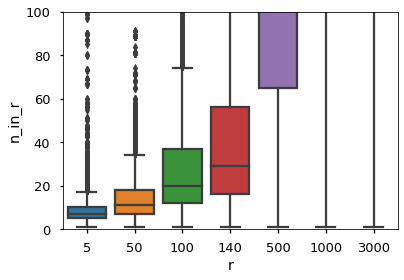

In [573]:
sns.boxplot(x="r", y="n_in_r", data=bar)
plt.ylim([0,100])

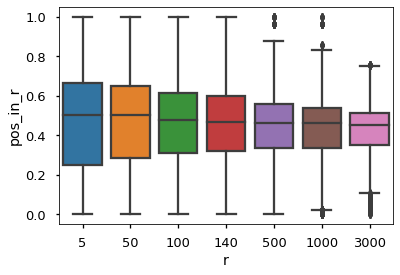

In [574]:
sns.boxplot(x="r", y="pos_in_r", data=bar)
# plt.ylim([0,100])

In [582]:
backgrd_df = bar[bar["r"]==3000]
t1 = backgrd_df[backgrd_df["pos_in_r"] < 0.2]


In [583]:
print(len(t1))
ft1 = bar[np.in1d(bar["person_id"], t1["person_id"])]

2312


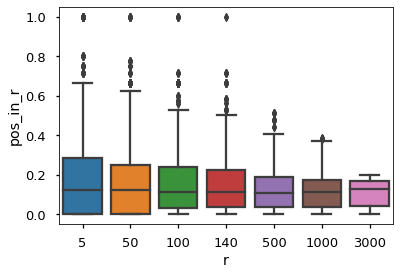

In [584]:
sns.boxplot(x="r", y="pos_in_r", data=ft1)

In [ ]:
for i, sdf in bar.groupby("person_id"):
    

In [586]:
for rd in range(2,11):
    print(rd)
    sdf = df[df["round"]==rd]
    foo = add_xy_coords_metric(sdf, recenter=True)

    d = np.array(foo[["x", "y"]])
    ckdt = cKDTree(d)

    pos_cut = foo["rdt_pos"]==1
    pos_individuals_xy = np.array(foo[["x", "y"]][pos_cut])
    
    get_positivity_at_radii(foo, ckdt, savename="rd_{}_positivity.csv".format(str(rd).zfill(2)))

2


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


1000
2000
3000
4000
5000
6000
7000
8000
3
0
1000
2000
3000
4000
5000
6000
7000
4
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
5
0
1000
2000
3000
4000
5000
6000
7000
6
0
1000
2000
3000
4000
5000
6000
7000
7
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
8
0
1000
2000
3000
4000
9
0
1000
2000
3000
4000
5000
6000
7000
8000
10
0
1000
2000


In [590]:
# Aggregate all dataframes into one
df_list = []
for rd in range(1,11):
    fn = "rd_{}_positivity.csv".format(str(rd).zfill(2))
    
    hdf = pd.read_csv(fn)
    hdf["round"] = rd
    
    df_list.append(hdf)
    
agg_df = pd.concat(df_list, ignore_index=True)
agg_df.to_csv("all_rds_positivity.csv", index=False)

In [588]:
fn

'rd_10_positivity.csv'

In [594]:
backgrd_df = agg_df[agg_df["r"]==3000].reset_index(drop=True)

In [596]:
backgrd_df["pos_backgrd"] = backgrd_df["pos_in_r"]

In [597]:
agg2 = agg_df.merge(backgrd_df[["person_id", "round", "pos_backgrd"]], how="left", on=["person_id", "round"])

In [599]:
agg2["relative_enrichment"] = agg2["pos_in_r"]/agg2["pos_backgrd"]

In [601]:
agg2.to_csv("all_rds_positivity.csv", index=False)

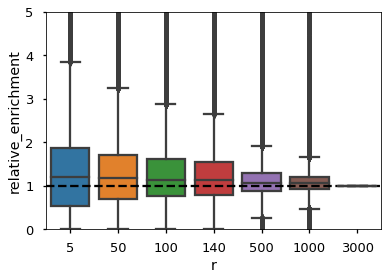

In [606]:
sns.boxplot(x="r",y="relative_enrichment",data=agg2)
plt.ylim([0,5])
plt.axhline(1,color='black', linestyle='dashed')

In [615]:
agg2["num_pos"] = agg2["n_in_r"]*agg2["pos_in_r"]
x = agg2.groupby("r").agg({"num_pos":"sum",
                           "n_in_r": "sum"}).reset_index()

In [617]:
x["ratio"] = x["num_pos"]/x["n_in_r"]

Text(0.5, 1.0, 'Summed across all index cases across all rounds')

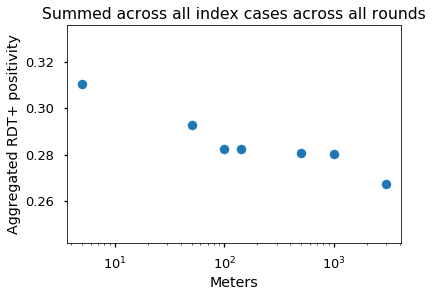

In [622]:
plt.scatter(x["r"], x["ratio"])
plt.xscale('log')
plt.xlabel("Meters")
plt.ylabel("Aggregated RDT+ positivity")
plt.title("Summed across all index cases across all rounds")

In [644]:
def return_summed_df(df, return_diff=False):
    df["num_pos"] = df["n_in_r"] * df["pos_in_r"]
    x = df.groupby("r").agg({"num_pos": "sum", "n_in_r": "sum"}).reset_index()
    if return_diff:
        x["num_pos"] = np.diff(x["num_pos"],prepend=0)
        x["n_in_r"] = np.diff(x["n_in_r"],prepend=0)
    x["ratio"] = x["num_pos"]/x["n_in_r"]
    return x
    

1


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2
3
4
5
6


Text(0.5, 1.0, 'Summed across all index cases across all rounds')

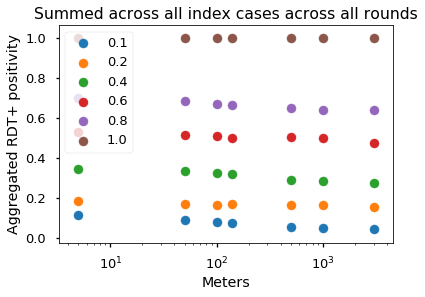

In [630]:
# transmission_bins
transmission_bins = np.array([0,0.1,0.2,0.4,0.6,0.8,1])

plt.figure()
for i in np.arange(1,len(transmission_bins)):
    print(i)
    tb_cut = np.logical_and(agg2["pos_backgrd"]> transmission_bins[i-1], agg2["pos_backgrd"]<= transmission_bins[i])
    sdf = return_summed_df(agg2[tb_cut])
    plt.scatter(sdf["r"], sdf["ratio"], label=transmission_bins[i])
    plt.xscale('log')
plt.xlabel("Meters")
plt.ylabel("Aggregated RDT+ positivity")
plt.legend()
plt.title("Summed across all index cases across all rounds")
    
    

1


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2
3
4
5
6


Text(0.5, 1.0, 'Summed across all index cases across all rounds')

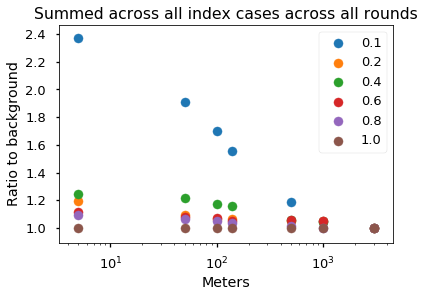

In [631]:
# transmission_bins
transmission_bins = np.array([0,0.1,0.2,0.4,0.6,0.8,1])

plt.figure()
for i in np.arange(1,len(transmission_bins)):
    print(i)
    tb_cut = np.logical_and(agg2["pos_backgrd"]> transmission_bins[i-1], agg2["pos_backgrd"]<= transmission_bins[i])
    sdf = return_summed_df(agg2[tb_cut])
    bckgrd = sdf["ratio"][sdf["r"]==3000].iloc[0]
    plt.scatter(sdf["r"], sdf["ratio"]/bckgrd, label=transmission_bins[i])
    plt.xscale('log')
plt.xlabel("Meters")
plt.ylabel("Ratio to background")
plt.legend()
plt.title("Summed across all index cases across all rounds")

1
3178


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2
7420
3
56007
4
57449
5
122318


Text(0.5, 1.0, 'Summed across all index cases across all rounds')

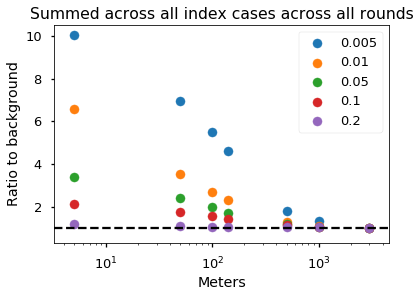

In [634]:
# transmission_bins
transmission_bins = np.array([0,0.005,0.01,0.05,0.1,0.2])

plt.figure()
for i in np.arange(1,len(transmission_bins)):
    print(i)
    tb_cut = np.logical_and(agg2["pos_backgrd"]> transmission_bins[i-1], agg2["pos_backgrd"]<= transmission_bins[i])
    sdf = return_summed_df(agg2[tb_cut])
    bckgrd = sdf["ratio"][sdf["r"]==3000].iloc[0]
    plt.scatter(sdf["r"], sdf["ratio"]/bckgrd, label=transmission_bins[i])
    plt.xscale('log')
plt.axhline(1, color='black', linestyle='dashed')
plt.xlabel("Meters")
plt.ylabel("Ratio to background")
plt.legend()
plt.title("Summed across all index cases across all rounds")

1


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2
3
4
5


Text(0.5, 1.0, 'Summed across all index cases across all rounds')

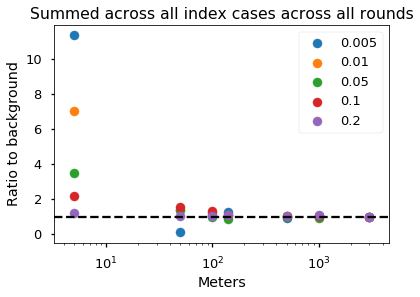

In [645]:
# transmission_bins
transmission_bins = np.array([0,0.005,0.01,0.05,0.1,0.2])

plt.figure()
for i in np.arange(1,len(transmission_bins)):
    print(i)
    tb_cut = np.logical_and(agg2["pos_backgrd"]> transmission_bins[i-1], agg2["pos_backgrd"]<= transmission_bins[i])
    sdf = return_summed_df(agg2[tb_cut], return_diff=True)
    bckgrd = sdf["ratio"][sdf["r"]==3000].iloc[0]
    plt.scatter(sdf["r"], sdf["ratio"]/bckgrd, label=transmission_bins[i])
    plt.xscale('log')
plt.axhline(1, color='black', linestyle='dashed')
plt.xlabel("Meters")
plt.ylabel("Ratio to background")
plt.legend()
plt.title("Summed across all index cases across all rounds")

In [635]:
xx = sdf["ratio"]/bckgrd

In [643]:
np.diff(xx,prepend=0)

array([ 1.19288641e+00, -9.67342816e-02, -3.10140746e-02,  4.45854572e-03,
       -2.07900379e-02, -7.53655258e-05, -4.87311937e-02])

In [648]:
agg2.columns

Index(['person_id', 'r', 'n_in_r', 'pos_in_r', 'round', 'pos_backgrd',
       'relative_enrichment', 'num_pos'],
      dtype='object')

## Aggregating a different way: preserve distributions

In [803]:
agg2 = pd.read_csv("all_rds_positivity.csv")

In [646]:
transmission_bins = np.array([0,0.005,0.01,0.05,0.1,0.2])

In [678]:
transmission_cut = np.logical_and(agg2["pos_backgrd"] > 0.1, agg2["pos_backgrd"] < 0.2)
test_df = agg2[transmission_cut]
test_df["npos_in_r"] = test_df["n_in_r"]*test_df["pos_in_r"]

c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [679]:
n50l = []
np50l = []
for pid, sdf in test_df.groupby("person_id"):
    n_at_50_bin = sdf[sdf["r"]==50]["n_in_r"].iloc[0] - sdf[sdf["r"]==5]["n_in_r"].iloc[0]
    n_pos_at_50_bin = sdf[sdf["r"]==50]["npos_in_r"].iloc[0] - sdf[sdf["r"]==5]["npos_in_r"].iloc[0]
    
    n50l.append(n_at_50_bin)
    np50l.append(n_pos_at_50_bin)

In [680]:
bin50_df = pd.DataFrame({
    "n": n50l,
    "npos": np50l
})
bin50_df["pos_rate"] = bin50_df["npos"]/bin50_df["n"]

In [681]:
print(len(bin50_df))
print(np.sum(bin50_df["n"]>=5))

16063
6319


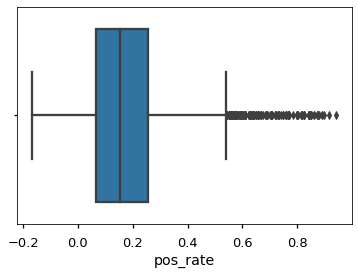

In [682]:
interesting_cut = bin50_df["n"]>=5
# plt.hist(bin50_df[interesting_cut]["npos"], bins=np.arange(50))
sns.boxplot(bin50_df[interesting_cut]["pos_rate"])

In [756]:
def return_enhancement_df(agg_df, background_positivity_range, radius_range):
    transmission_cut = np.logical_and(agg_df["pos_backgrd"] > background_positivity_range[0], 
                                      agg_df["pos_backgrd"] < background_positivity_range[1])
    test_df = agg_df[transmission_cut]
    test_df["npos_in_r"] = test_df["n_in_r"]*test_df["pos_in_r"]
    
    n_l = []
    np_l = []
    pb_l = []
    for pid, sdf in test_df.groupby("person_id"):
        if radius_range[0] > 0:
            n_at_r_bin = sdf[sdf["r"]==radius_range[1]]["n_in_r"].iloc[0] - sdf[sdf["r"]==radius_range[0]]["n_in_r"].iloc[0]
            n_pos_at_r_bin = sdf[sdf["r"]==radius_range[1]]["npos_in_r"].iloc[0] - sdf[sdf["r"]==radius_range[0]]["npos_in_r"].iloc[0]
        else:
            n_at_r_bin = sdf[sdf["r"]==radius_range[1]]["n_in_r"].iloc[0]
            n_pos_at_r_bin = sdf[sdf["r"]==radius_range[1]]["npos_in_r"].iloc[0]

            
        n_l.append(n_at_r_bin)
        np_l.append(n_pos_at_r_bin)
        pb_l.append(sdf["pos_backgrd"].iloc[0])
    
    save_df = pd.DataFrame({
        "n": n_l,
        "npos": np_l,
        "pos_background": pb_l
    })
    save_df["pos_rate"] = save_df["npos"]/save_df["n"]
    
    return save_df

In [757]:
transmission_bins = np.array([0,0.005,0.01,0.05,0.1,0.2])

df_list = []

for tbi in np.arange(len(transmission_bins)):
    print(tbi)
    if tbi > 0:
        tb_min = transmission_bins[tbi-1]
        tb_max = transmission_bins[tbi]
        test_df = return_enhancement_df(agg2, [tb_min,tb_max], [0.,5.])
        df_list.append(test_df.copy())

0
1


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


2
3
4
5


In [758]:
dist_df = pd.concat(df_list)
dist_df["transmission_category"] = ""

transmission_bins = np.array([0,0.005,0.01,0.05,0.1,0.2])

for tbi in np.arange(len(transmission_bins)):
    print(tbi)
    if tbi > 0:
        cut = np.logical_and(dist_df["pos_background"] >= transmission_bins[tbi-1],
                            dist_df["pos_background"] < transmission_bins[tbi])
        dist_df["transmission_category"][cut] = "{}-{}".format(transmission_bins[tbi-1],
                                                              transmission_bins[tbi])

0
1


c:\users\jsuresh\venv\idm\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


2
3
4
5


In [759]:
test_df = dist_df[dist_df["n"] >= 5]
test_df = test_df.dropna()
test_df.loc[test_df["pos_rate"]<0, "pos_rate"]=0
test_df["enrichment"] = (test_df["pos_rate"]-test_df["pos_background"])/test_df["pos_background"]

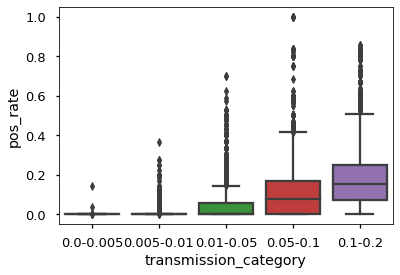

In [713]:
sns.boxplot(x="transmission_category", y="pos_rate", data=test_df)

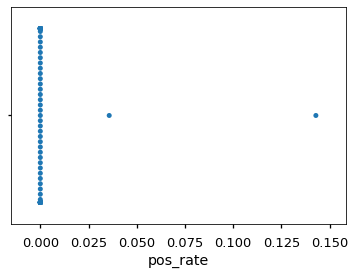

In [718]:
sns.swarmplot(test_df[test_df["transmission_category"]=="0.0-0.005"]["pos_rate"])
# plt.xlim([0,0.01])

AttributeError: module 'matplotlib.pyplot' has no attribute 'x'

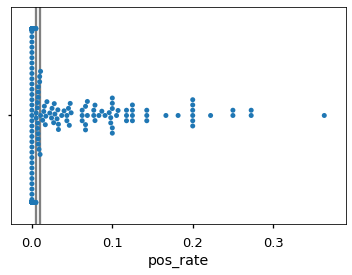

In [721]:
sns.swarmplot(test_df[test_df["transmission_category"]=="0.005-0.01"]["pos_rate"])
plt.axvline(0.005, color='gray')
plt.axvline(0.01, color='gray')
plt.x

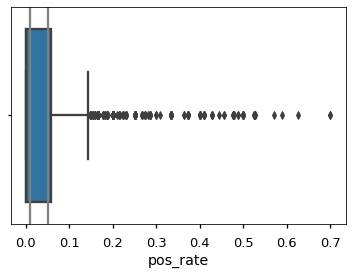

In [723]:
sns.boxplot(test_df[test_df["transmission_category"]=="0.01-0.05"]["pos_rate"])
plt.axvline(0.01, color='gray')
plt.axvline(0.05, color='gray')
# plt.x

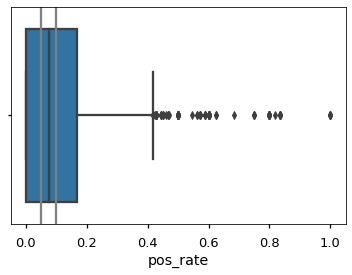

In [724]:
sns.boxplot(test_df[test_df["transmission_category"]=="0.05-0.1"]["pos_rate"])
plt.axvline(0.05, color='gray')
plt.axvline(0.1, color='gray')
# plt.x

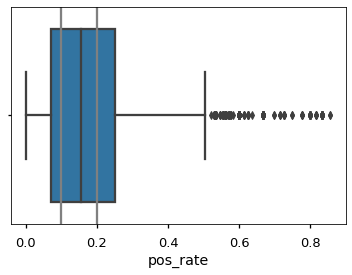

In [725]:
sns.boxplot(test_df[test_df["transmission_category"]=="0.1-0.2"]["pos_rate"])
plt.axvline(0.1, color='gray')
plt.axvline(0.2, color='gray')
# plt.x

In [760]:
# Perhaps another way: plot fraction of cases where you find >X times the max, for different X
ef_l = []
tc_l = []
frac_l = []
for enrich_factor in [1,1.5,2]:
    for tc, sdf in test_df.groupby("transmission_category"):
#         print(tc)
        num = np.sum(sdf["pos_rate"] > enrich_factor * sdf["pos_background"])
        denom = len(sdf)
        frac_above = num/denom
#         print(num/denom)

        ef_l.append(enrich_factor)
        tc_l.append(tc)
        frac_l.append(frac_above)
        
save_df = pd.DataFrame({
    "enrich_factor": ef_l,
    "transmission_category": tc_l,
    "frac_above": frac_l
})

(0, 0.65)

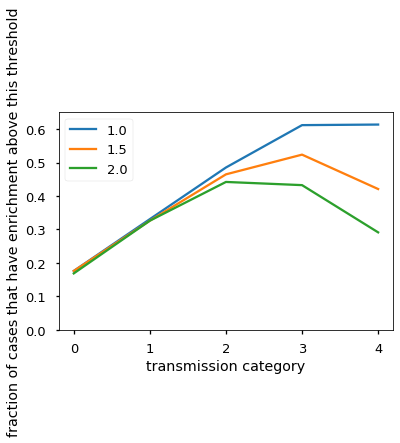

In [762]:
for i, sdf in save_df.groupby("enrich_factor"):
    
    plt.plot(np.arange(len(sdf)), sdf["frac_above"], label=i)
plt.legend()
plt.xlabel("transmission category")
plt.ylabel("fraction of cases that have enrichment above this threshold")
plt.ylim([0,0.65])

In [744]:
print(sdf["transmission_category"].iloc[3])

0.05-0.1


In [753]:
dist_df.to_csv("r50_100_distributions.csv", index=False)

## Jan 16 for wiki post

In [764]:
agg2.columns

Index(['person_id', 'r', 'n_in_r', 'pos_in_r', 'round', 'pos_backgrd',
       'relative_enrichment', 'num_pos'],
      dtype='object')

In [829]:
agg_hh = agg2[agg2["r"]==5].dropna()
agg_hh = agg_hh[agg_hh["n_in_r"] >= 2]

Low:  0.0
High:  0.005
num in this bin  424
15.37247607781403
Low:  0.005
High:  0.01
num in this bin  1000
10.0625844066685
Low:  0.01
High:  0.05
num in this bin  7612
4.388073768957989
Low:  0.05
High:  0.1
num in this bin  7861
2.3405559576094723
Low:  0.1
High:  0.2
num in this bin  16784
1.5594557156472328


Text(0, 0.5, 'Household-level enrichment')

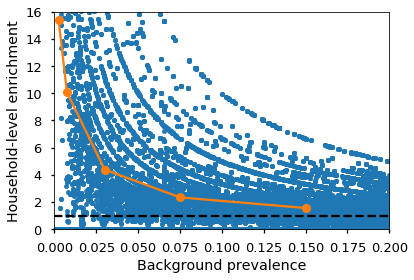

In [805]:

plt.scatter(agg_hh["pos_backgrd"], agg_hh["relative_enrichment"], marker='.', label="Individuals")

# Plot binned version:
# prev_bins = np.linspace(0,0.2,20)
prev_bins = np.array([0,0.005,0.01,0.05,0.1,0.2])
prev_dat = (prev_bins[1:]+prev_bins[:-1])/2. #center bins
mean_dat = []
for i in range(len(prev_bins)-1):
    print("Low: ", prev_bins[i])
    print("High: ", prev_bins[i+1])
    cut = np.logical_and(agg_hh["pos_backgrd"] > prev_bins[i], agg_hh["pos_backgrd"] <= prev_bins[i+1])
    print("num in this bin ", np.sum(cut))
    center = np.mean(agg_hh["relative_enrichment"][cut])
    print(center)
    mean_dat.append(center)
mean_dat = np.array(mean_dat)
plt.plot(prev_dat, mean_dat, color='C1', marker='o',label='Mean')

# plt.xlim([0,1])
plt.xlim([0,0.2])
plt.ylim([0,16])
plt.axhline(1, color='black', linestyle='dashed')
plt.xlabel("Background prevalence")
plt.ylabel("Household-level enrichment")

In [860]:
agg_50 = agg2[agg2["r"]==50].dropna()

agg_diff = agg_50[["person_id", "n_in_r", "num_pos", "pos_backgrd"]].rename(columns={"n_in_r": "n_in_r50",
                                                                     "num_pos": "num_pos_r50"}).merge(agg_hh[["person_id", "n_in_r", "num_pos"]].rename(columns={"n_in_r": "n_in_r5",
                                                                                                                                                     "num_pos": "num_pos_r5"}), on="person_id")


agg_diff["n_in_r5to50"] = agg_diff["n_in_r50"]-agg_diff["n_in_r5"]
agg_diff["npos_in_r5to50"] = agg_diff["num_pos_r50"]-agg_diff["num_pos_r5"]
agg_diff["pos_in_r5to50"] = agg_diff["npos_in_r5to50"]/agg_diff["n_in_r5to50"]
agg_diff["enrich"] = agg_diff["pos_in_r5to50"]/agg_diff["pos_backgrd"]
# agg_hh = agg_hh[agg_hh["n_in_r"] >= 2]
agg_diff = agg_diff.dropna()

Low:  0.0
High:  0.022222222222222223
num in this bin  2245
1.670611134136644
Low:  0.022222222222222223
High:  0.044444444444444446
num in this bin  2155
1.34695871125857
Low:  0.044444444444444446
High:  0.06666666666666667
num in this bin  2570
1.6565406304203947
Low:  0.06666666666666667
High:  0.08888888888888889
num in this bin  1753
1.536628060306366
Low:  0.08888888888888889
High:  0.11111111111111112
num in this bin  2200
1.7609352080529377
Low:  0.11111111111111112
High:  0.13333333333333333
num in this bin  1546
1.4618821621670215
Low:  0.13333333333333333
High:  0.15555555555555556
num in this bin  2136
1.1128750275829005
Low:  0.15555555555555556
High:  0.17777777777777778
num in this bin  92690
0.7229077772831818
Low:  0.17777777777777778
High:  0.2
num in this bin  2410
1.0136080746150296


Text(0, 0.5, '5-to-50 meters enrichment')

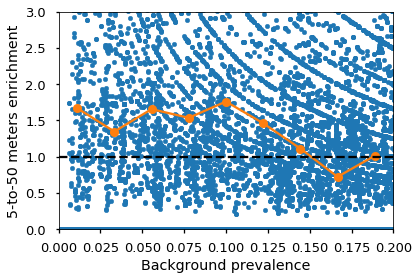

In [861]:
plt.scatter(agg_diff["pos_backgrd"], agg_diff["enrich"], marker='.', label="Individuals")

# Plot binned version:
prev_bins = np.linspace(0,0.2,10)
# prev_bins = np.array([0,0.005,0.01,0.05,0.1,0.2])
prev_dat = (prev_bins[1:]+prev_bins[:-1])/2. #center bins
mean_dat = []
for i in range(len(prev_bins)-1):
    print("Low: ", prev_bins[i])
    print("High: ", prev_bins[i+1])
    cut = np.logical_and(agg_diff["pos_backgrd"] > prev_bins[i], agg_diff["pos_backgrd"] <= prev_bins[i+1])
    print("num in this bin ", np.sum(cut))
    center = np.mean(agg_diff["enrich"][cut])
    print(center)
    mean_dat.append(center)
mean_dat = np.array(mean_dat)
plt.plot(prev_dat, mean_dat, color='C1', marker='o',label='Mean')

# plt.xlim([0,1])
plt.xlim([0,0.2])
plt.ylim([0,3])
plt.axhline(1, color='black', linestyle='dashed')
plt.xlabel("Background prevalence")
plt.ylabel("5-to-50 meters enrichment")

In [819]:
len(agg_diff)

617314

In [820]:
agg_50.columns

Index(['person_id', 'r', 'n_in_r', 'pos_in_r', 'round', 'pos_backgrd',
       'relative_enrichment', 'num_pos'],
      dtype='object')

In [854]:
agg_100 = agg2[agg2["r"]==100].dropna()
agg_50 = agg2[agg2["r"]==50].dropna()

agg_diff = agg_100[["person_id", "n_in_r", "num_pos", "pos_backgrd"]].rename(columns={"n_in_r": "n_in_r100",
                                                                     "num_pos": "num_pos_r100"}).merge(agg_50[["person_id", "n_in_r", "num_pos"]].rename(columns={"n_in_r": "n_in_r50",
                                                                                                                                                     "num_pos": "num_pos_r50"}), on="person_id")


agg_diff["n_in_r50to100"] = agg_diff["n_in_r100"]-agg_diff["n_in_r50"]
agg_diff["npos_in_r50to100"] = agg_diff["num_pos_r100"]-agg_diff["num_pos_r50"]
agg_diff["pos_in_r50to100"] = agg_diff["npos_in_r50to100"]/agg_diff["n_in_r50to100"]
agg_diff["enrich"] = agg_diff["pos_in_r50to100"]/agg_diff["pos_backgrd"]
# agg_hh = agg_hh[agg_hh["n_in_r"] >= 2]
agg_diff = agg_diff.dropna()

Low:  0.0
High:  0.022222222222222223
num in this bin  3458
0.9036117832059094
Low:  0.022222222222222223
High:  0.044444444444444446
num in this bin  7389
0.35044080411525136
Low:  0.044444444444444446
High:  0.06666666666666667
num in this bin  2808
1.2224127488845473
Low:  0.06666666666666667
High:  0.08888888888888889
num in this bin  2060
1.107567347487622
Low:  0.08888888888888889
High:  0.11111111111111112
num in this bin  2208
1.000041512527638
Low:  0.11111111111111112
High:  0.13333333333333333
num in this bin  1872
1.323539948176201
Low:  0.13333333333333333
High:  0.15555555555555556
num in this bin  2469
1.2782045943639055
Low:  0.15555555555555556
High:  0.17777777777777778
num in this bin  117946
1.5820963419802225
Low:  0.17777777777777778
High:  0.2
num in this bin  3809
1.0954879919525835


Text(0, 0.5, '50-to-100 meters enrichment')

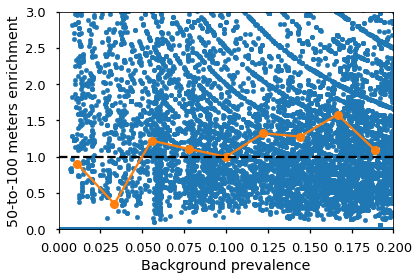

In [855]:
plt.scatter(agg_diff["pos_backgrd"], agg_diff["enrich"], marker='.', label="Individuals")

# Plot binned version:
prev_bins = np.linspace(0,0.2,10)
# prev_bins = np.array([0,0.005,0.01,0.05,0.1,0.2])
prev_dat = (prev_bins[1:]+prev_bins[:-1])/2. #center bins
mean_dat = []
for i in range(len(prev_bins)-1):
    print("Low: ", prev_bins[i])
    print("High: ", prev_bins[i+1])
    cut = np.logical_and(agg_diff["pos_backgrd"] > prev_bins[i], agg_diff["pos_backgrd"] <= prev_bins[i+1])
    print("num in this bin ", np.sum(cut))
    center = np.mean(agg_diff["enrich"][cut])
    print(center)
    mean_dat.append(center)
mean_dat = np.array(mean_dat)
plt.plot(prev_dat, mean_dat, color='C1', marker='o',label='Mean')

# plt.xlim([0,1])
plt.xlim([0,0.2])
plt.ylim([0,3])
plt.axhline(1, color='black', linestyle='dashed')
plt.xlabel("Background prevalence")
plt.ylabel("50-to-100 meters enrichment")

In [857]:
agg_50 = agg2[agg2["r"]==140].dropna()

agg_diff = agg_50[["person_id", "n_in_r", "num_pos", "pos_backgrd"]].rename(columns={"n_in_r": "n_in_r140",
                                                                     "num_pos": "num_pos_r140"}).merge(agg_hh[["person_id", "n_in_r", "num_pos"]].rename(columns={"n_in_r": "n_in_r5",
                                                                                                                                                     "num_pos": "num_pos_r5"}), on="person_id")


agg_diff["n_in_r5to140"] = agg_diff["n_in_r140"]-agg_diff["n_in_r5"]
agg_diff["npos_in_r5to140"] = agg_diff["num_pos_r140"]-agg_diff["num_pos_r5"]
agg_diff["pos_in_r5to140"] = agg_diff["npos_in_r5to140"]/agg_diff["n_in_r5to140"]
agg_diff["enrich"] = agg_diff["pos_in_r5to140"]/agg_diff["pos_backgrd"]
# agg_hh = agg_hh[agg_hh["n_in_r"] >= 2]
agg_diff = agg_diff.dropna()

Low:  0.0
High:  0.022222222222222223
num in this bin  4372
1.2885040718615817
Low:  0.022222222222222223
High:  0.044444444444444446
num in this bin  8168
0.5091420408759567
Low:  0.044444444444444446
High:  0.06666666666666667
num in this bin  3809
1.4835062307892912
Low:  0.06666666666666667
High:  0.08888888888888889
num in this bin  2849
1.3238904237264695
Low:  0.08888888888888889
High:  0.11111111111111112
num in this bin  3140
1.450090359681997
Low:  0.11111111111111112
High:  0.13333333333333333
num in this bin  2525
1.2373910925593983
Low:  0.13333333333333333
High:  0.15555555555555556
num in this bin  3171
1.2158197445089987
Low:  0.15555555555555556
High:  0.17777777777777778
num in this bin  118708
0.9509471560694153
Low:  0.17777777777777778
High:  0.2
num in this bin  4713
1.0921810962699887


Text(0, 0.5, '5-to-140 meters enrichment')

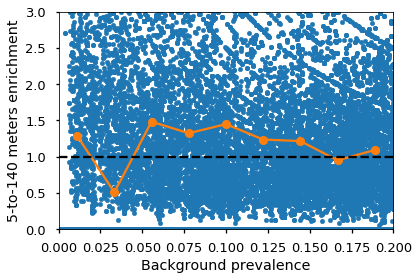

In [859]:
plt.scatter(agg_diff["pos_backgrd"], agg_diff["enrich"], marker='.', label="Individuals")

# Plot binned version:
prev_bins = np.linspace(0,0.2,10)
# prev_bins = np.array([0,0.005,0.01,0.05,0.1,0.2])
prev_dat = (prev_bins[1:]+prev_bins[:-1])/2. #center bins
mean_dat = []
for i in range(len(prev_bins)-1):
    print("Low: ", prev_bins[i])
    print("High: ", prev_bins[i+1])
    cut = np.logical_and(agg_diff["pos_backgrd"] > prev_bins[i], agg_diff["pos_backgrd"] <= prev_bins[i+1])
    print("num in this bin ", np.sum(cut))
    center = np.mean(agg_diff["enrich"][cut])
    print(center)
    mean_dat.append(center)
mean_dat = np.array(mean_dat)
plt.plot(prev_dat, mean_dat, color='C1', marker='o',label='Mean')

# plt.xlim([0,1])
plt.xlim([0,0.2])
plt.ylim([0,3])
plt.axhline(1, color='black', linestyle='dashed')
plt.xlabel("Background prevalence")
plt.ylabel("5-to-140 meters enrichment")

## Splitting by population density

In [862]:
agg_50 = agg2[agg2["r"]==50].dropna()

agg_diff = agg_50[["person_id", "n_in_r", "num_pos", "pos_backgrd"]].rename(columns={"n_in_r": "n_in_r50",
                                                                     "num_pos": "num_pos_r50"}).merge(agg_hh[["person_id", "n_in_r", "num_pos"]].rename(columns={"n_in_r": "n_in_r5",
                                                                                                                                                     "num_pos": "num_pos_r5"}), on="person_id")


agg_diff["n_in_r5to50"] = agg_diff["n_in_r50"]-agg_diff["n_in_r5"]
agg_diff["npos_in_r5to50"] = agg_diff["num_pos_r50"]-agg_diff["num_pos_r5"]
agg_diff["pos_in_r5to50"] = agg_diff["npos_in_r5to50"]/agg_diff["n_in_r5to50"]
agg_diff["enrich"] = agg_diff["pos_in_r5to50"]/agg_diff["pos_backgrd"]
# agg_hh = agg_hh[agg_hh["n_in_r"] >= 2]
agg_diff = agg_diff.dropna()

In [872]:
agg_diff.describe()

,n_in_r50,num_pos_r50,pos_backgrd,n_in_r5,num_pos_r5,n_in_r5to50,npos_in_r5to50,pos_in_r5to50,enrich
count,144107.000000,144107.000000,144107.000000,144107.000000,144107.000000,144107.000000,1.441070e+05,1.441070e+05,1.441070e+05
mean,448.906195,51.698724,0.197354,144.411861,16.008938,304.494334,3.568979e+01,1.773143e-01,8.909842e-01
std,316.433180,34.434401,0.111009,117.101284,11.891305,222.810357,2.608474e+01,1.808387e-01,1.052355e+00
min,3.000000,0.000000,0.001188,2.000000,0.000000,1.000000,-7.105427e-15,-2.368476e-15,-2.908090e-14
25%,23.000000,8.000000,0.156406,9.000000,3.000000,13.000000,4.000000e+00,1.108830e-01,7.089432e-01
50%,689.000000,75.000000,0.156406,202.000000,21.000000,487.000000,5.400000e+01,1.108830e-01,7.089432e-01
75%,689.000000,75.000000,0.187141,202.000000,21.000000,487.000000,5.400000e+01,1.111111e-01,7.104019e-01
max,689.000000,202.000000,0.750000,473.000000,93.000000,677.000000,1.950000e+02,1.000000e+00,6.481481e+01


Prev: 0.0 to 0.022222222222222223
count: 0 to 5
num in this bin  674
Prev: 0.022222222222222223 to 0.044444444444444446
count: 0 to 5
num in this bin  708
Prev: 0.044444444444444446 to 0.06666666666666667
count: 0 to 5
num in this bin  628
Prev: 0.06666666666666667 to 0.08888888888888889
count: 0 to 5
num in this bin  626
Prev: 0.08888888888888889 to 0.11111111111111112
count: 0 to 5
num in this bin  810
Prev: 0.11111111111111112 to 0.13333333333333333
count: 0 to 5
num in this bin  525
Prev: 0.13333333333333333 to 0.15555555555555556
count: 0 to 5
num in this bin  726
Prev: 0.15555555555555556 to 0.17777777777777778
count: 0 to 5
num in this bin  806
Prev: 0.17777777777777778 to 0.2
count: 0 to 5
num in this bin  926
Prev: 0.0 to 0.022222222222222223
count: 5 to 10
num in this bin  1228
Prev: 0.022222222222222223 to 0.044444444444444446
count: 5 to 10
num in this bin  1165
Prev: 0.044444444444444446 to 0.06666666666666667
count: 5 to 10
num in this bin  1060
Prev: 0.06666666666666667 

Text(0, 0.5, '5-to-50 meters enrichment')

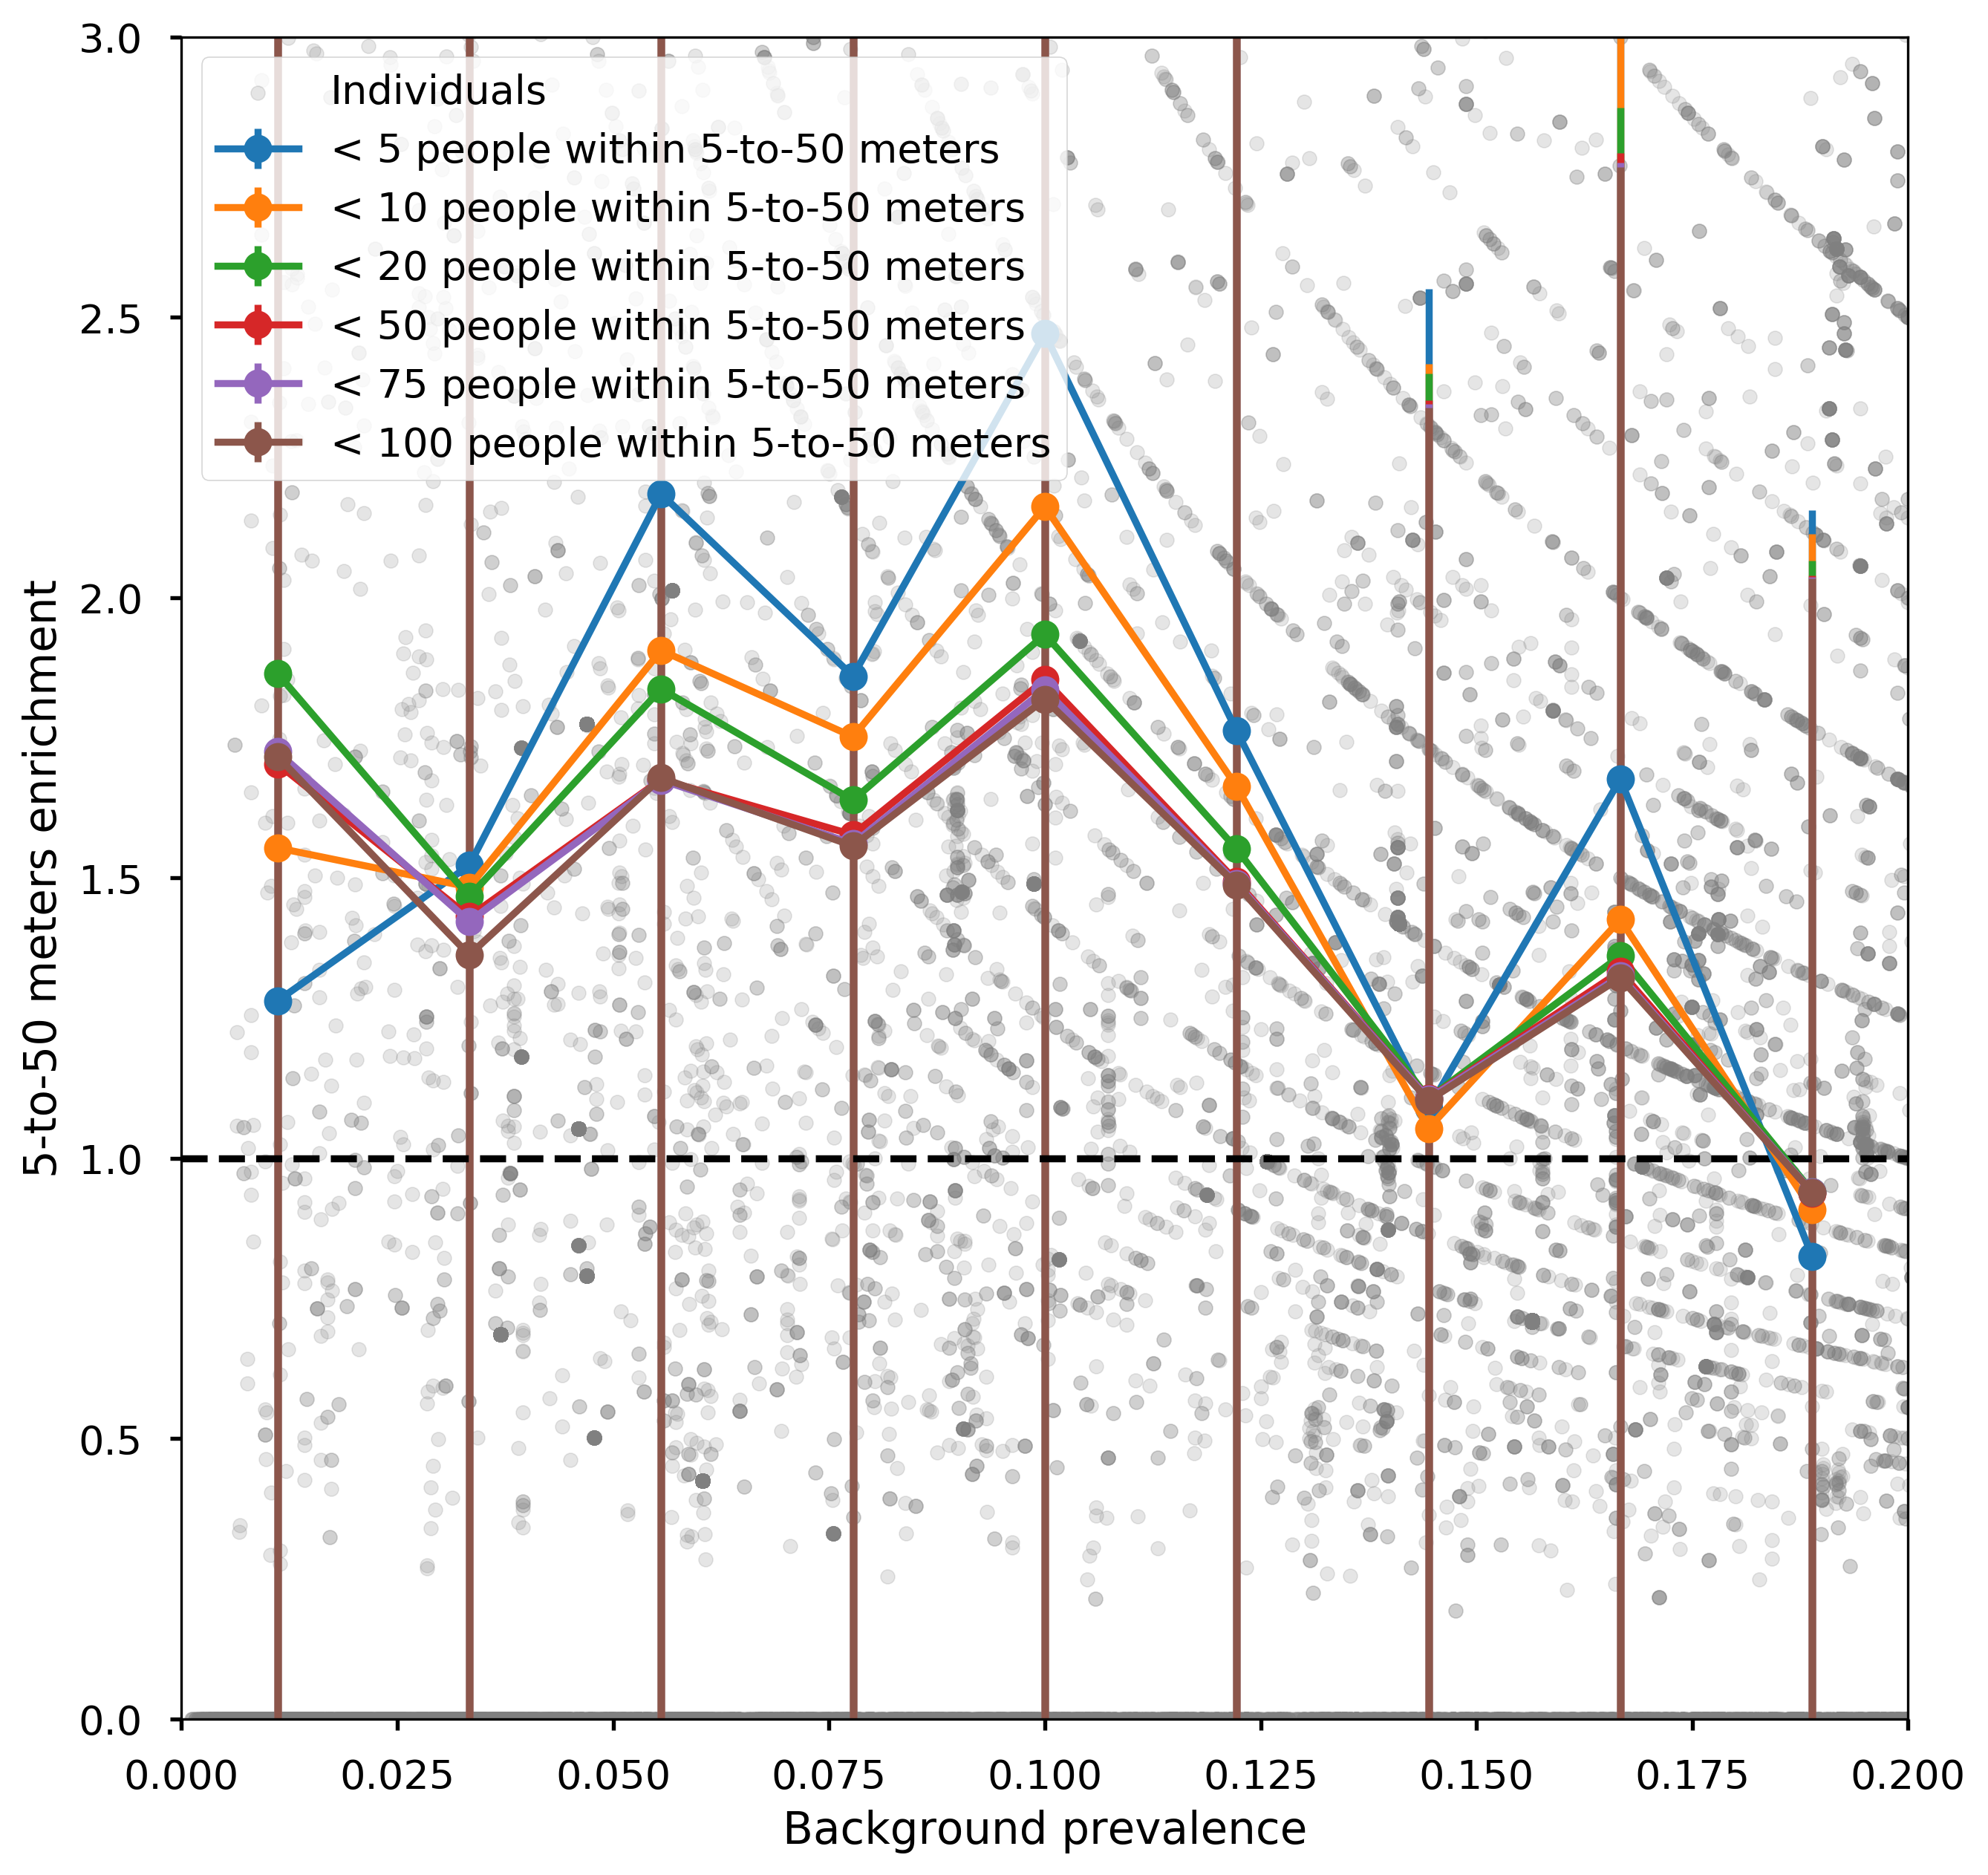

In [902]:
plt.figure(figsize=(10,10), dpi=300)
plt.scatter(agg_diff["pos_backgrd"], agg_diff["enrich"], marker='.', label="Individuals", color="gray", alpha=0.2)

# Plot binned version:
prev_bins = np.linspace(0,0.2,10)
# count_bins = np.linspace(0,650,5)
# count_bins = np.array([0,5,10,20,50,75,100,300])
count_bins = np.array([0,5,10,20,50,75,100])
# prev_bins = np.array([0,0.005,0.01,0.05,0.1,0.2])
prev_dat = (prev_bins[1:]+prev_bins[:-1])/2. #center bins


for j in range(len(count_bins)-1):
    mean_dat = []
    std_dat = []
#     cut2 = np.logical_and(agg_diff["n_in_r5to50"] > count_bins[j], agg_diff["n_in_r5to50"] <= count_bins[j+1])
    cut2 = agg_diff["n_in_r5to50"] <= count_bins[j+1]
    for i in range(len(prev_bins)-1):
        cut = np.logical_and(agg_diff["pos_backgrd"] > prev_bins[i], agg_diff["pos_backgrd"] <= prev_bins[i+1])
#         print("Low: ", prev_bins[i])
#         print("High: ", prev_bins[i+1])
        
        fullcut = np.logical_and(cut,cut2)
        print("Prev: {} to {}".format(prev_bins[i], prev_bins[i+1]))
        print("count: {} to {}".format(count_bins[j], count_bins[j+1]))
        print("num in this bin ", np.sum(fullcut))
        center = np.mean(agg_diff["enrich"][fullcut])
        width = np.std(agg_diff["enrich"][fullcut])
#         print(center)
        mean_dat.append(center)
        std_dat.append(width)
    mean_dat = np.array(mean_dat)
    std_dat = np.array(std_dat)
#     lbl = "{} to {} people within 5-to-50 meters".format(count_bins[j],count_bins[j+1])
    lbl = "< {} people within 5-to-50 meters".format(count_bins[j+1])
    plt.errorbar(prev_dat, mean_dat, std_dat, marker='o',label=lbl)

# plt.xlim([0,1])
plt.xlim([0,0.2])
plt.ylim([0,3])
plt.axhline(1, color='black', linestyle='dashed')
plt.legend()
plt.xlabel("Background prevalence")
plt.ylabel("5-to-50 meters enrichment")

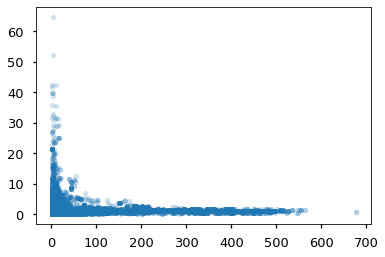

In [865]:
plt.scatter(agg_diff["n_in_r5to50"], agg_diff["enrich"], marker='.', alpha=0.2)

(array([1.6794e+04, 1.3823e+04, 7.8710e+03, 3.8440e+03, 2.0850e+03,
        1.2060e+03, 7.4700e+02, 9.2400e+02, 4.2500e+02, 2.7500e+02,
        2.1700e+02, 1.8300e+02, 2.4200e+02, 1.3900e+02, 3.7300e+02,
        2.7700e+02, 1.0200e+02, 1.2400e+02, 7.4000e+01, 1.1500e+02,
        1.4200e+02, 8.7000e+01, 9.9000e+01, 1.0800e+02, 1.5100e+02,
        5.7000e+01, 7.9000e+01, 6.2000e+01, 5.2000e+01, 5.1000e+01,
        5.4000e+01, 3.4000e+01, 3.6000e+01, 9.5000e+01, 4.9000e+01,
        6.1000e+01, 1.2600e+02, 6.0000e+01, 4.3000e+01, 6.0000e+01,
        5.6000e+01, 2.1000e+01, 6.7930e+03, 2.0000e+01, 3.8000e+01,
        3.6000e+01, 3.9000e+01, 1.9000e+01, 4.5000e+01, 4.1000e+01,
        1.4000e+01, 4.3000e+01, 8.1000e+01, 2.8000e+01, 5.9000e+01,
        3.8000e+01, 4.0000e+01, 3.2000e+01, 5.2000e+01, 4.3000e+01,
        8.1000e+01, 8.2000e+01, 5.8000e+01, 9.0000e+01, 8.0000e+00,
        4.1000e+01, 4.1000e+01, 3.7000e+01, 6.0000e+01, 6.0000e+00,
        3.5000e+01, 3.4000e+01, 2.7000e+01, 4.40

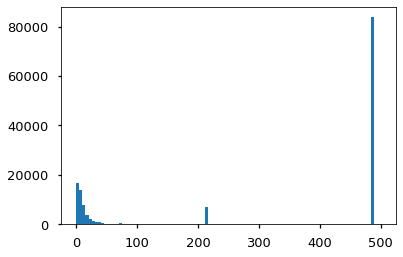

In [869]:
plt.hist(agg_diff["n_in_r5to50"], bins=np.linspace(0,500,100))

In [871]:
agg_diff[agg_diff["n_in_r5to50"]>400]

,person_id,n_in_r50,num_pos_r50,pos_backgrd,n_in_r5,num_pos_r5,n_in_r5to50,npos_in_r5to50,pos_in_r5to50,enrich
3654,uuid:d8d4dd11-45a9-41d7-9a84-aed6403558c7,473.0,95.0,0.323356,26.0,8.0,447.0,87.0,0.194631,0.601909
3655,uuid:c25be647-d87a-43bc-bd17-810e3f2ac646,473.0,95.0,0.323356,26.0,8.0,447.0,87.0,0.194631,0.601909
3656,uuid:adf2b74f-160f-4f28-821d-caa3661f0465,473.0,95.0,0.323356,26.0,8.0,447.0,87.0,0.194631,0.601909
3657,uuid:59c1b1ad-4d7e-46e3-9379-744ac7cc43ae,473.0,95.0,0.323356,26.0,8.0,447.0,87.0,0.194631,0.601909
3658,uuid:f7817b26-e02e-48b6-a71b-40f90bc48e31,473.0,95.0,0.323356,26.0,8.0,447.0,87.0,0.194631,0.601909
3659,uuid:d3a80d21-914b-4e95-9e96-373b4d1eae9d,473.0,95.0,0.323356,26.0,8.0,447.0,87.0,0.194631,0.601909
3660,uuid:a96f9d79-16ee-4c1a-998d-f0526ca347b6,473.0,95.0,0.323356,26.0,8.0,447.0,87.0,0.194631,0.601909
10865,uuid:7b10bc81-0e00-4875-836b-acd35f6dbf4e,476.0,92.0,0.323232,26.0,8.0,450.0,84.0,0.186667,0.577500
10866,uuid:43cb780e-61a2-481b-b76f-a7a8a343c25c,476.0,92.0,0.323232,26.0,8.0,450.0,84.0,0.186667,0.577500
11641,uuid:ddcecc3c-6f5f-416e-9716-e503088b5ccc,440.0,83.0,0.324675,25.0,0.0,415.0,83.0,0.200000,0.616000


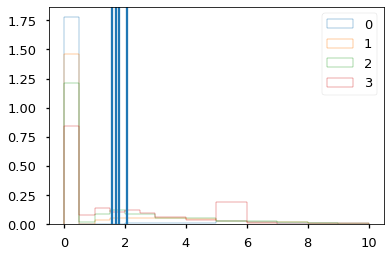

In [920]:
foo = agg_diff[agg_diff["n_in_r5to50"] <= 20]
enrich_bins = [0,0.5,1,1.5,2,2.5,3,4,5,6,7,8,9,10]

prev_bins = np.linspace(0,0.1,5)
for i in np.arange(len(prev_bins)-1):
    cut = np.logical_and(foo["pos_backgrd"] > prev_bins[i], foo["pos_backgrd"] <= prev_bins[i+1])
    
    plt.hist(foo[cut]["enrich"], bins=enrich_bins, histtype="step", label=i, alpha=1, density=True)
    plt.axvline(np.mean(foo[cut]["enrich"]))
plt.legend()

In [904]:
len(foo)

42332

In [905]:
foo.describe()

,n_in_r50,num_pos_r50,pos_backgrd,n_in_r5,num_pos_r5,n_in_r5to50,npos_in_r5to50,pos_in_r5to50,enrich
count,42332.000000,42332.000000,42332.000000,42332.000000,42332.000000,42332.000000,4.233200e+04,4.233200e+04,4.233200e+04
mean,15.958495,5.157942,0.273526,8.119508,2.776103,7.838987,2.381839e+00,2.963268e-01,1.215067e+00
std,10.716197,4.539819,0.160296,9.292748,3.172004,4.813275,2.651526e+00,2.748441e-01,1.838252e+00
min,3.000000,0.000000,0.001188,2.000000,0.000000,1.000000,-7.105427e-15,-2.368476e-15,-2.908090e-14
25%,10.000000,2.000000,0.152027,4.000000,1.000000,4.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,14.000000,4.000000,0.260823,6.000000,2.000000,7.000000,2.000000e+00,2.500000e-01,9.314869e-01
75%,20.000000,7.000000,0.406708,9.000000,4.000000,11.000000,4.000000e+00,5.000000e-01,1.576149e+00
max,289.000000,70.000000,0.750000,276.000000,70.000000,20.000000,1.700000e+01,1.000000e+00,6.481481e+01


In [ ]:
prev_bins = np.linspace(0,0.2,10)